# RNN-LSTMs in Keras Demo with IMDB data

## This is my own RNN-LSTM to predict the last word in a sentence

In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.optimizers import RMSprop
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5004)

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
max_features = 500
emb_dim = 10
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features)
X_train, X_test = X_train[0:10], X_test[0:10]

# Taking the last element of X_train[i] as our outcome
Y_train = np.asarray([i[-1] for i in X_train]) 
Y_test = np.asarray([ i[-1] for i in X_test])

# Removing the last element of X_train[i]
X_train = np.asarray([i[:-1] for i in X_train]) 
X_test = np.asarray([i[:-1] for i in X_test] )


windx = imdb.get_word_index()
rwindx = dict((k,v) for v,k in windx.items())

# Proof it the index swap worked
print( windx['fawn'])
print( rwindx[34701])

# Looking at one set of data
print( X_train[0])

# Let's see the words
print( [rwindx[x] for x in X_train[0]])

34701
fawn
[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178]
['the', 'as', 'you', 'with', 'out', 'and', 'and', 'and', 'and', 'their', 'becomes', 'and', 'had', 'and', 'of', 'lot', 'from', 'anyone', 'to', 'h

In [3]:
len(X_train)

10

In [4]:
# RNN for the regular embedings
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
# The pad sequences stuff seems suspicious
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

10 train sequences
10 test sequences
Pad sequences (samples x time)
X_train shape: (10, 80)
X_test shape: (10, 80)


In [18]:
X_train.shape

(10, 80)

In [5]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, emb_dim, dropout=0.2))
model.add(LSTM(150))
model.add(Dense(max_features))
model.add(Activation('softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

optimizer = RMSprop(lr=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1,
          validation_data=(X_test, Y_test), verbose=0)

# Running the predictions
out = model.evaluate(X_test, Y_test, batch_size=batch_size)
ypred_tst = model.predict(X_test)

print('Cross Entropy Loss of %0.3f' % out)

yprdtst = np.argmax(ypred_tst, axis=1)
x = confusion_matrix(yprdtst, Y_test).astype('float') 
# Normalizing it
x_n = x/ x.sum(axis=0)

print ('Classification Accuracy is %0.3f' % (np.diag(x).sum()/ x.sum()))

Build model...
Train...
10/10 [==============================] - 0s
Cross Entropy Loss of 5.292
Classification Accuracy is 0.400


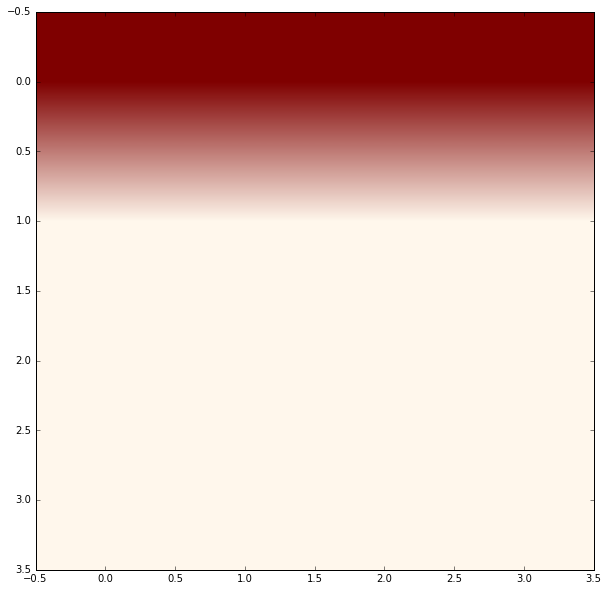

In [6]:
# Look at the confusion matrix image
plt.figure(figsize=(15,10))
plt.imshow(x_n, cmap='OrRd')
plt.show()

In [7]:
len(model.get_weights())

15

In [8]:
np.unique(X_train), len(np.unique(X_train)), len(range(np.min(X_train), np.max(X_train)+1)) # Have to do +1

(array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  18,  19,  20,  21,  22,  23,  24,  25,  26,  28,
         30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  55,  56,  57,
         58,  60,  61,  63,  64,  65,  67,  68,  69,  71,  72,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  85,  87,  88,  89,  91,
         92,  93,  94,  95,  96,  98,  99, 103, 104, 106, 108, 112, 113,
        115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144,
        145, 148, 152, 154, 156, 161, 163, 164, 165, 166, 168, 170, 173,
        174, 175, 177, 178, 180, 182, 189, 191, 194, 195, 196, 197, 199,
        202, 207, 211, 215, 219, 220, 224, 226, 227, 228, 233, 235, 238,
        242, 243, 245, 247, 251, 253, 256, 257, 259, 267, 270, 271, 272,
        277, 278, 279, 280, 283, 285, 296, 297, 298

In [11]:
model.get_weights()[0].shape

(500, 10)

In [12]:
[ [j.shape for j in l.get_weights()] for l in model.layers]

[[(500, 10)],
 [(10, 150),
  (150, 150),
  (150,),
  (10, 150),
  (150, 150),
  (150,),
  (10, 150),
  (150, 150),
  (150,),
  (10, 150),
  (150, 150),
  (150,)],
 [(150, 500), (500,)],
 []]

In [13]:
# Embedding layers
embs = model.layers[0].get_weights()[0]
embs.shape

(500, 10)

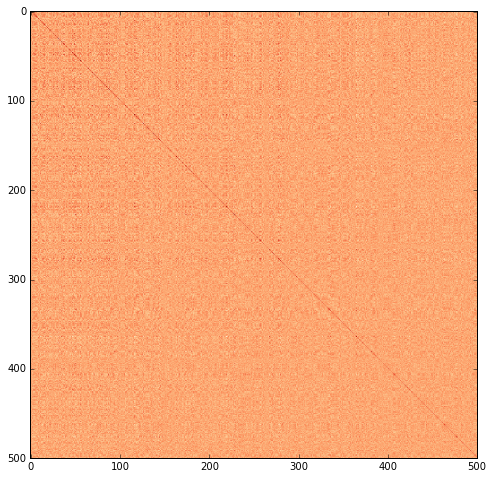

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(embs.dot(embs.T), cmap='OrRd')
plt.show()

In [15]:
uniqs = np.unique(X_train)
min_x, max_x = np.min(X_train), np.max(X_train)
print(uniqs)
print("%i unique values"% len(uniqs) )
print('Ranging from %i to %i' % (min_x, max_x) )
if min_x==0:
    max_x+=1
print("Which means we have an index matrix with %i words" % (max_x-min_x) )

[  0   1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  18  19
  20  21  22  23  24  25  26  28  30  31  32  33  34  35  36  37  38  39
  40  42  43  44  45  46  47  48  49  50  51  52  53  55  56  57  58  60
  61  63  64  65  67  68  69  71  72  74  75  76  77  78  79  80  81  82
  83  85  87  88  89  91  92  93  94  95  96  98  99 103 104 106 108 112
 113 115 116 118 119 120 121 122 123 124 125 126 127 128 129 131 132 134
 135 136 137 138 139 140 141 143 144 145 148 152 154 156 161 163 164 165
 166 168 170 173 174 175 177 178 180 182 189 191 194 195 196 197 199 202
 207 211 215 219 220 224 226 227 228 233 235 238 242 243 245 247 251 253
 256 257 259 267 270 271 272 277 278 279 280 283 285 296 297 298 299 317
 326 333 334 335 344 349 357 364 369 371 375 381 400 406 419 421 423 429
 431 462 474 476 480 481 486 491]
206 unique values
Ranging from 0 to 491
Which means we have an index matrix with 492 words


In [16]:
# The indexing below is correct
# -- note that we don't have a 3 in our np.unique(X_train) so we only have 40 unique values b/c we start at 0
# -- which is inserted by the padding function, and note that we don't have 0 in our dictionary list
# --
sims = embs.dot( embs[windx['film']].reshape((10,1)))
for i, si in enumerate(sims):
    if i==0:
        continue
    print(i, rwindx[i], si)
        
print('Closest match is %i' % np.delete(sims, windx['film']).argmax())

1 the [-0.00507453]
2 and [ 0.01272907]
3 a [ 0.00018414]
4 of [ 0.00139191]
5 to [-0.00056279]
6 is [ 0.00212838]
7 br [ 0.0043973]
8 in [ 0.00131518]
9 it [-0.00308434]
10 i [-0.00134535]
11 this [-0.00358874]
12 that [ 0.00543737]
13 was [-0.00138412]
14 as [ 0.00543767]
15 for [ 0.00066177]
16 with [ 0.00510834]
17 movie [ 0.00381955]
18 but [-0.00272863]
19 film [ 0.01721811]
20 on [-0.00465776]
21 not [-0.00251285]
22 you [ 0.00556881]
23 are [-0.00494909]
24 his [ 0.00322551]
25 have [-0.00732203]
26 he [ 0.00365461]
27 be [  1.82858203e-05]
28 one [-0.00115753]
29 all [ 0.00463819]
30 at [-0.00031107]
31 by [-0.00506875]
32 an [-0.00012868]
33 they [-0.00106187]
34 who [-0.0064911]
35 so [ 0.00835707]
36 from [ 0.00014184]
37 like [ 0.00591003]
38 her [ 0.00863082]
39 or [-0.00527858]
40 just [-0.0011065]
41 about [ 0.00505101]
42 it's [ 0.00398988]
43 out [ 0.00023499]
44 has [-0.00253199]
45 if [-0.00076354]
46 some [ 0.00360494]
47 there [-0.00526443]
48 what [-0.0008602]
49

In [ ]:
rwindx[3]

In [ ]:
# Here are the words in the model
print( [rwindx[x] for x in np.unique(X_train).tolist() if x!=0])

----

## This is the original RNN-LSTM-MLP for IMDB Classification {0,1}

Original Source: https://github.com/fchollet/keras/blob/master/examples/imdb_lstm.py

    from __future__ import print_function
    import numpy as np
    np.random.seed(1337)  # for reproducibility

    from keras.preprocessing import sequence
    from keras.utils import np_utils
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Embedding
    from keras.layers import LSTM, SimpleRNN, GRU
    from keras.datasets import imdb
    from keras.optimizers import RMSprop
    from sklearn.metrics import roc_auc_score

    max_features = 200
    maxlen = 80  # cut texts after this number of words (among top max_features most common words)
    batch_size = 32

    # This is the original IMDB model, it's an LSTM feeding into an MLP

    print('Loading data...')

    (X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features)

    print(len(X_train), 'train sequences')
    print(len(X_test), 'test sequences')

    print('Pad sequences (samples x time)')
    X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
    X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)

    print('Build model...')
    model = Sequential()
    model.add(Embedding(max_features, 128, dropout=0.2))
    model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2))  # try using a GRU instead, for fun
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # try using different optimizers and different optimizer configs
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    print('Train...')
    model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1,
              validation_data=(X_test, y_test), verbose=0)
    score, acc = model.evaluate(X_test, y_test,
                                batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)
    ypred_tst = model.predict(X_test)
    # Pretty good AUC
    print('Test AUC:', roc_auc_score(y_test,ypred_tst))